In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from photoholmes.utils.image import read_image, read_jpeg_data

def plot_image(image, title="Image"):
    if isinstance(image, bytes):
        image = np.frombuffer(image, np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [13]:
def prepare_image(image):
    return torch.from_numpy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).transpose(2, 0, 1))


def ensure_jpeg(image):
    encode_param = [cv2.IMWRITE_JPEG_QUALITY, 95]

    success, encoded_img = cv2.imencode(".jpg", image, encode_param)
    if success:
        decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
        if decoded_img is not None:
            return prepare_image(decoded_img)

    return cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

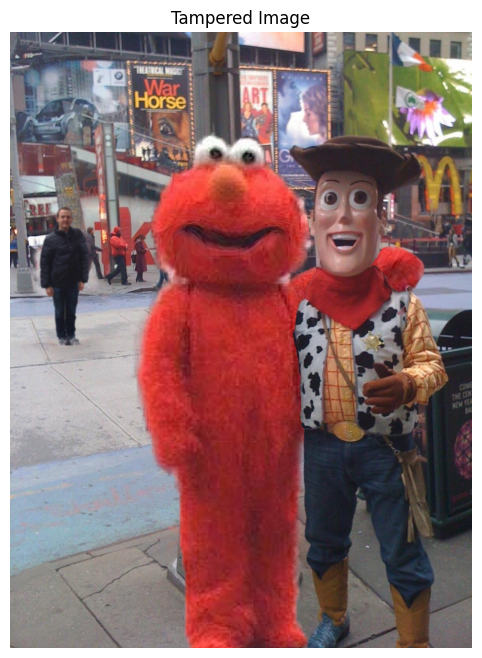

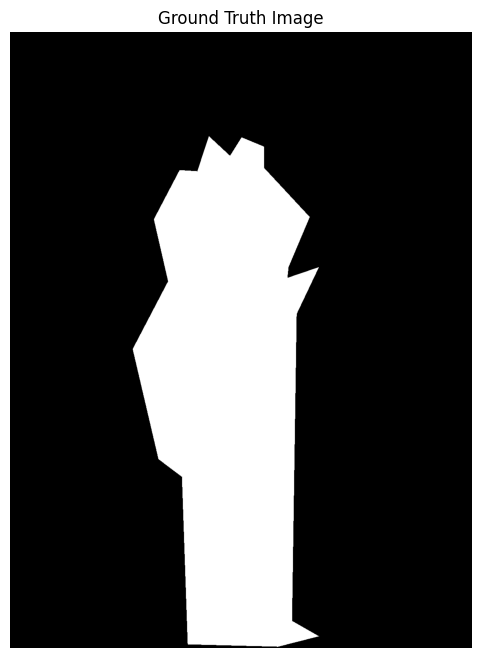

In [14]:
img_folder = "/home/nhat82125/ForgeryX-Server/example"
img_name = "im1_edit3"

tp_img_path = os.path.join(img_folder, f"{img_name}.jpg")
gt_img_path = os.path.join(img_folder, f"{img_name}.png")

tp_img_cv = cv2.imread(tp_img_path)
tp_img = ensure_jpeg(tp_img_cv)

gt_img = read_image(gt_img_path)

plot_image(tp_img.permute(1, 2, 0).numpy(), "Tampered Image")
plot_image(gt_img.permute(1, 2, 0).numpy(), "Ground Truth Image")

In [15]:
from photoholmes.methods.dq import DQ, dq_preprocessing

dct, qtables = read_jpeg_data(tp_img_path)

image_data = {"image": tp_img, "dct_coefficients": dct}
input = dq_preprocessing(**image_data)

method = DQ()
output = method.predict(**input)

In [16]:
binary_image = np.array(output, dtype=np.float32)
normalized_image = cv2.normalize(
    binary_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap = cv2.applyColorMap(
    normalized_image, cv2.COLORMAP_JET)

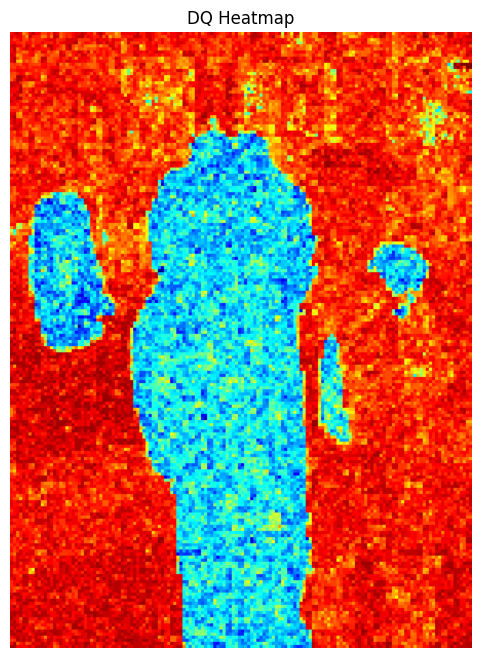

In [17]:
plot_image(heatmap, "DQ Heatmap")